Assignment Title (Lab 3) : Predictive Modeling for Insurance Claims
NAME: NAKIIBINGE Gideon

REG. NO.: 2023/HD05/04696U

STUDENT NO.: 2300704696

MASTER OF SCIENCE IN COMPUTER SCIENCE - (MCSC)



Objective:
Build a predictive model to determine if a building will have an insurance claim during a specific period using building characteristics. In this assignment, you will explore and apply four machine learning algorithms: Support Vector Machine (SVM), Linear Regression, k-nearest Neighbors (KNN), and Naive Bayes. The evaluation metric for this assignment is the Area Under the Curve (AUC).


Variable	Description	
Customer Id	                          Identification number for the Policy holder	
YearOfObservation	                  year of observation for the insured policy	
Insured_Period	                      duration of insurance policy in Olusola Insurance. (Ex: Full year insurance, Policy Duration = 1; 6 months = 0.5	
Residential	                          is the building a residential building or not	
Building_Painted	                  is the building painted or not (N-Painted, V-Not Painted)	
Building_Fenced	                      is the building fence or not (N-Fenced, V-Not Fenced)	
Garden	building                      has garden or not (V-has garden	 O-no garden)
Settlement	                          Area where the building is located. (R- rural area	 U- urban area)
Building Dimension	                  Size of the insured building in m2	
Building_Type	                      The type of building (Type 1, 2, 3, 4)	
Date_of_Occupancy	                  date building was first occupied	
NumberOfWindows	                      number of windows in the building	
Geo Code	                          Geographical Code of the Insured building	
Claim	                              target variable. (0: no claim, 1: at least one claim over insured period).	


In [1]:
# Importing important packages
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import classification_report
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from IPython.display import VimeoVideo
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.utils.validation import check_is_fitted
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score


# Prepare Data

In [2]:
# Using a function during data wrangling so that the process of data cleaning is not so repetitive 
def wrangle(filepath):
    # Read csv file into data frame
    df = pd.read_csv(filepath)
    
    # Remove missing values from the data set
    # The code for dealing with categorical variables 
    #fill missing values with mode value
    df['Garden'].fillna(df['Garden'].mode()[0],inplace=True)
    df['Geo_Code'].fillna(df['Geo_Code'].mode()[0],inplace=True)
    #fill missing values with median
    df['Building Dimension'].fillna(df['Building Dimension'].median(),inplace=True)
    df['Date_of_Occupancy'].fillna(df['Date_of_Occupancy'].median(),inplace=True)
    
    #replace  . in the NumberOfWindows with None since it means they are missing value
    df['NumberOfWindows'].replace(('   .'), 'None', inplace=True)
    
    #Remove outliers by "Building Dimension"
    lower, higher = df["Building Dimension"].quantile([0.1, 0.9])
    mask_dim = df["Building Dimension"].between(lower, higher)
    df=df[mask_dim]

# Remove outliers by "Date_of_Occupancy"
    low, high = df["Date_of_Occupancy"].quantile([0.1, 0.9])
    mask_date = df["Date_of_Occupancy"].between(low, high)
    df = df[mask_date]

# Dropping unwanted columns like customer Id 
    df = df.drop("Customer Id", axis=1)
    df = df.drop("NumberOfWindows", axis=1)
    df = df.drop("Geo_Code", axis=1)
    
    
    return df

In [3]:
# Importing the training data set  by invoking the wrangle function
df = wrangle("train_data.csv")
print("df shape", df.shape)
df.head(10)

df shape (4686, 11)


,YearOfObservation,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Building_Type,Date_of_Occupancy,Claim
2,2014,1.000000,0,N,V,V,U,595.0,1,1960.0,0
3,2013,1.000000,0,V,V,V,U,2840.0,1,1960.0,0
5,2012,1.000000,0,V,N,O,R,535.0,1,1980.0,0
6,2012,1.000000,0,N,V,V,U,2830.0,1,1988.0,0
10,2013,0.241096,0,V,N,O,R,550.0,1,1960.0,0
11,2013,1.000000,0,V,V,V,U,910.0,1,1960.0,0
14,2012,1.000000,0,N,V,V,U,560.0,1,1960.0,0
16,2014,1.000000,0,N,V,V,U,3990.0,1,1988.0,1
17,2015,1.000000,0,N,V,V,U,3990.0,1,1988.0,0
18,2015,1.000000,0,V,N,O,R,2444.0,1,1970.0,0


At this point , the shape of our data frame is 7160 observations (rows) and 14 features (variables)

# Checking for missing values 
The first step was to check if our data had any missing values as this might impact highly on all other parts of the analysis. 


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7160 entries, 0 to 7159
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Customer Id         7160 non-null   object 
 1   YearOfObservation   7160 non-null   int64  
 2   Insured_Period      7160 non-null   float64
 3   Residential         7160 non-null   int64  
 4   Building_Painted    7160 non-null   object 
 5   Building_Fenced     7160 non-null   object 
 6   Garden              7160 non-null   object 
 7   Settlement          7160 non-null   object 
 8   Building Dimension  7160 non-null   float64
 9   Building_Type       7160 non-null   int64  
 10  Date_of_Occupancy   7160 non-null   float64
 11  NumberOfWindows     7160 non-null   object 
 12  Geo_Code            7160 non-null   object 
 13  Claim               7160 non-null   int64  
dtypes: float64(3), int64(4), object(7)
memory usage: 783.2+ KB


In [8]:
# Checking for missing values 
df.isnull().sum()

YearOfObservation     0
Insured_Period        0
Residential           0
Building_Painted      0
Building_Fenced       0
Garden                0
Settlement            0
Building Dimension    0
Building_Type         0
Date_of_Occupancy     0
Claim                 0
dtype: int64

The data has a significant number of missing values. Specifically the variables with missing values were as follows; Building Dimension (106), Date of Occupancy (508) , GeoCode (102) and Garden(7).

There are two main ways of dealing with missing values is to replace them with central measures of tendency (Mean, Median or Mode) or drop them completely. The mean and median work well with continuous variables while the Mode works well with categorical variables.

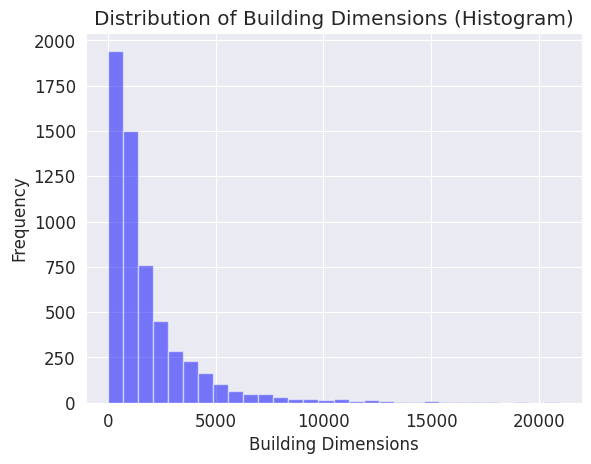

In [457]:
# Exploring Building Dimension dealing with missing values using a box plot 
plt.hist(df["Building Dimension"], bins=30, color='blue', alpha=0.5)
plt.xlabel("Building Dimensions")
plt.ylabel("Frequency")
plt.title("Distribution of Building Dimensions (Histogram)")
plt.show()

In [458]:
df["Building Dimension"].describe()

count     5776.000000
mean      1869.886080
std       2290.699871
min          1.000000
25%        533.500000
50%       1083.000000
75%       2240.000000
max      20940.000000
Name: Building Dimension, dtype: float64

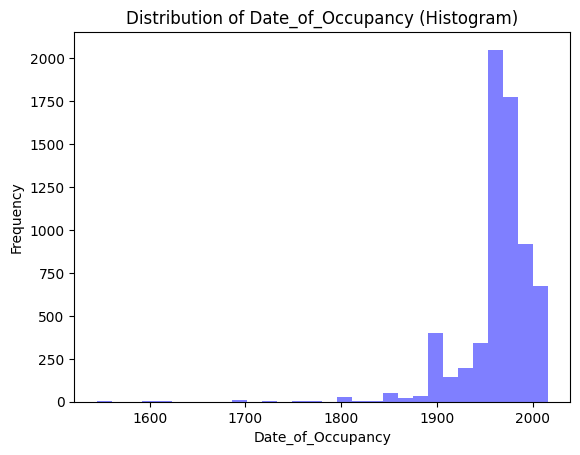

In [44]:
# Exploring the Date of occupancy  before dealing with missing values using a box plot 
plt.hist(df["Date_of_Occupancy"], bins=30, color='blue', alpha=0.5)
plt.xlabel("Date_of_Occupancy")
plt.ylabel("Frequency")
plt.title("Distribution of Date_of_Occupancy (Histogram)")
plt.show()

In [9]:
df["Date_of_Occupancy"].describe()

count    5751.000000
mean     1964.416449
std        35.069758
min      1545.000000
25%      1960.000000
50%      1970.000000
75%      1980.000000
max      2016.000000
Name: Date_of_Occupancy, dtype: float64

In [47]:
df["Date_of_Occupancy"].value_counts()

Date_of_Occupancy
1960.0    1818
1980.0    1155
1988.0     530
1900.0     371
1970.0     285
          ... 
1931.0       1
1824.0       1
1914.0       1
1846.0       1
1929.0       1
Name: count, Length: 134, dtype: int64

From the histograms we can tell that both variables have a skewed distribution. As a result, the median was chosen to replace the missing values. Since the GeoCode and Garden are categorical in nature, the mode is chosen to replace the missing values.

Note :I Assume took date of occupancy as a continuous variable

In [52]:
# The code for dealing with categorical $ variables was put in the wrangle function above


#fill missing values with mode value
#df['Garden'].fillna(df['Garden'].mode()[0],inplace=True)
#df['Geo_Code'].fillna(df['Geo_Code'].mode()[0],inplace=True)
#fill missing values with median
#df['Building Dimension'].fillna(df['Building Dimension'].median(),inplace=True)
#df['Date_of_Occupancy'].fillna(df['Date_of_Occupancy'].median(),inplace=True)


In [53]:
df.isnull().sum()

Customer Id           0
YearOfObservation     0
Insured_Period        0
Residential           0
Building_Painted      0
Building_Fenced       0
Garden                0
Settlement            0
Building Dimension    0
Building_Type         0
Date_of_Occupancy     0
NumberOfWindows       0
Geo_Code              0
Claim                 0
dtype: int64

In [55]:
# Checking for duplicates 
df.duplicated().sum()

0

No duplicates found

# Exploratory Data Analysis

### Exploring the target Variable Distribution

In [14]:
df["Claim"].unique()
df["Claim"].value_counts()

Claim
0    5526
1    1634
Name: count, dtype: int64

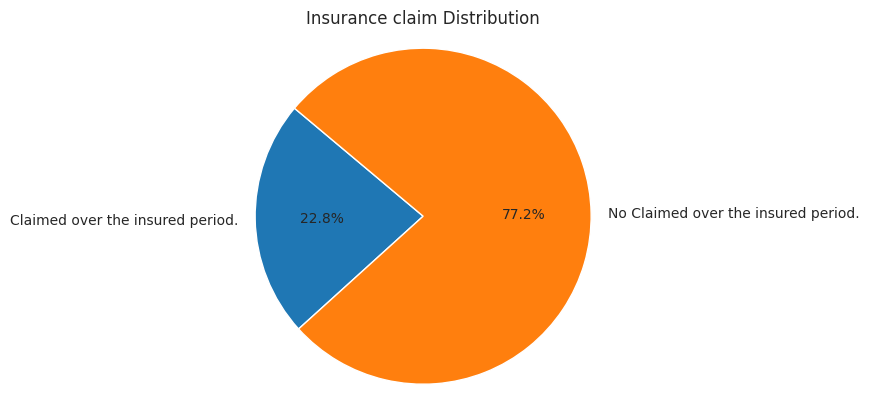

In [15]:
# Sample data (replace with your actual data)
values = [df["Claim"].sum(), len(df) - df["Claim"].sum()]
labels = ['Claimed over the insured period.', 'No Claimed over the insured period.']

# Create a pie chart with labeled segments
plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title("Insurance claim Distribution")

plt.axis('equal')  # Equal aspect ratio ensures that the pie chart is circular

plt.show()

The target variable is highly imbalanced , and so we shall need to balance it 

### Exploring other variables

#### 1. Continous  Variables 

In [19]:
df.describe()

,YearOfObservation,Insured_Period,Residential,Building Dimension,Building_Type,Date_of_Occupancy,Claim
count,4686.000000,4686.000000,4686.000000,4686.000000,4686.000000,4686.000000,4686.000000
mean,2013.666453,0.911699,0.293641,1389.158344,2.199744,1967.946223,0.209347
std,1.384444,0.240086,0.455478,982.316709,0.938338,15.541266,0.406886
min,2012.000000,0.000000,0.000000,330.000000,1.000000,1920.000000,0.000000
25%,2012.000000,1.000000,0.000000,600.000000,2.000000,1960.000000,0.000000
50%,2013.000000,1.000000,0.000000,1083.000000,2.000000,1970.000000,0.000000
75%,2015.000000,1.000000,1.000000,1900.000000,3.000000,1980.000000,0.000000
max,2016.000000,1.000000,1.000000,4300.000000,4.000000,1999.000000,1.000000


We can clearly see that we have outliers in Building Dimension and Date of Occupancy

We shall use the quantile method to remove the outliers
Add to your wrangle function so that it removes observations that are outliers in the "Building Dimension" and "Date of Occupancy" column. Specifically, all observations should fall between the 0.1 and 0.9 quantiles for these variables.

In [10]:
 # Remove outliers by "Building Dimension"
#low, high = df["Building Dimension"].quantile([0.1, 0.9])
#mask_dim = df["Building Dimension"].between(low, high)
#df=df[mask_dim]

# Remove outliers by "Date_of_Occupancy"
#low, high = df["Date_of_Occupancy"].quantile([0.1, 0.9])
#mask_date = df["Date_of_Occupancy"].between(low, high)
#df=df[mask_date]

Building Dimensions and Date of occupancy had outliers and these were removed using the quantile method.

### Distribution of insured period and Claim

In [71]:
df["Insured_Period"].unique()

array([1.        , 0.24109589, 0.84383562, 0.95628415, 0.99726776,
       0.08493151, 0.85753425, 0.29589041, 0.        , 0.78142077,
       0.91506849, 0.98630137, 0.16164384, 0.99726027, 0.09589041,
       0.66575343, 0.89315069, 0.02459016, 0.58082192, 0.83287671,
       0.26027397, 0.7479452 , 0.41803279, 0.10410959, 0.76986301,
       0.02465753, 0.47671233, 0.86575342, 0.55464481, 0.16393443,
       0.44808743, 0.50273224, 0.75136612, 0.08196721, 0.46849315,
       0.79726027, 0.31506849, 0.59452055, 0.74863388, 0.17534247,
       0.11780822, 0.12054795, 0.49589041, 0.91530055, 0.48087432,
       0.78082192, 0.02191781, 0.49453552, 0.2431694 , 0.24863388,
       0.69589041, 0.94794521, 0.91256831, 0.50410959, 0.82739726,
       0.52054795, 0.33333333, 0.58196721, 0.86885246, 0.57923497,
       0.83606557, 0.66393443, 0.98356164, 0.24657534, 0.99453552,
       0.74590164, 0.79178082, 0.19452055, 0.96721311, 0.41643836,
       0.95342466, 0.41369863, 0.25205479, 0.80273973, 0.98907

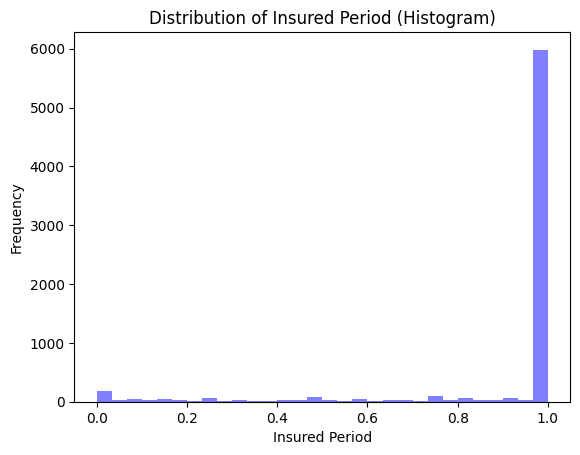

In [74]:
# Exploring Insured_period
plt.hist(df["Insured_Period"], bins=30, color='blue', alpha=0.5)
plt.xlabel("Insured Period")
plt.ylabel("Frequency")
plt.title("Distribution of Insured Period (Histogram)")
plt.show()

Text(0.5, 1.0, 'Distribution of Insured Period')

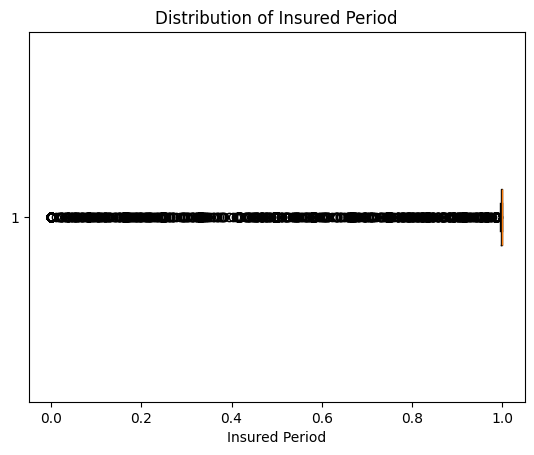

In [77]:
plt.boxplot(df["Insured_Period"],vert=False)
plt.xlabel("Insured Period")
plt.title("Distribution of Insured Period")

In [80]:
# Insured period vs Claim
mask_insured = df.groupby("Claim")["Insured_Period"].mean()
mask_insured

Claim
0    0.898193
1    0.948870
Name: Insured_Period, dtype: float64

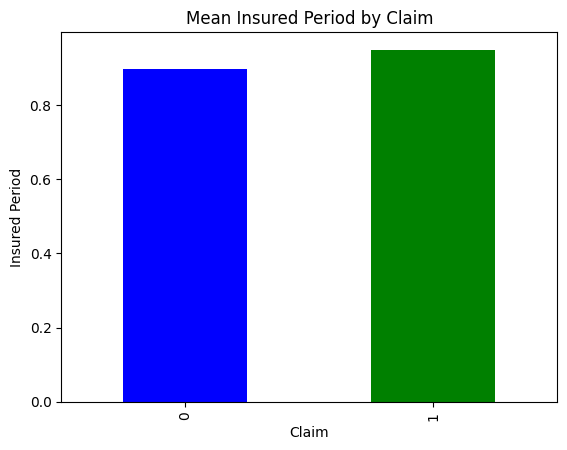

In [85]:
mask_insured.plot(
    kind = "bar",
    xlabel = "Claim",
    ylabel = "Insured Period",
    title = "Mean Insured Period by Claim",
    color=['blue', 'green']  # Specify the colors you want for each bar
);

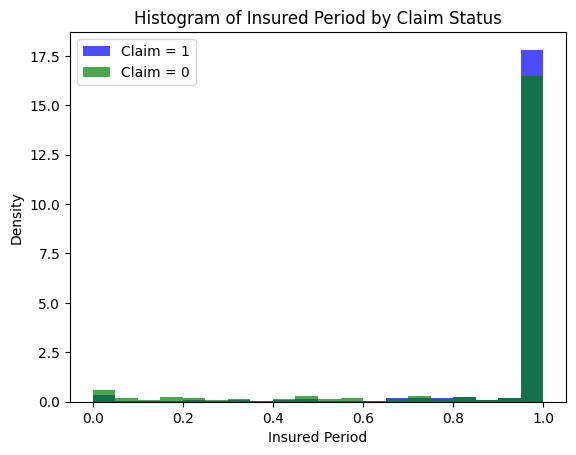

In [97]:
# Separate the data based on the 'Claim' values
claim_1 = df[df['Claim'] == 1]
claim_0 = df[df['Claim'] == 0]

# Create a histogram for 'Building Dimension' by 'Claim' category
plt.hist(claim_1['Insured_Period'], bins=20, alpha=0.7, color='blue', label='Claim = 1', density=True)
plt.hist(claim_0['Insured_Period'], bins=20, alpha=0.7, color='green', label='Claim = 0', density=True)

plt.xlabel('Insured Period')
plt.ylabel('Density')
plt.title('Histogram of Insured Period by Claim Status')
plt.legend()

plt.show()

The majority of the customers who claimed and also dnt claim had an insured period between 0.8 and 1

### Exporing Building dimensions and Claim

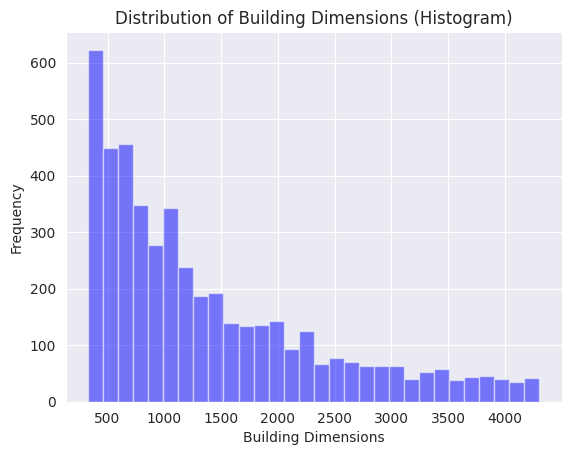

In [29]:
# Exploring Building Dimension dealing with missing values using a box plot 
plt.hist(df["Building Dimension"], bins=30, color='blue', alpha=0.5)
plt.xlabel("Building Dimensions")
plt.ylabel("Frequency")
plt.title("Distribution of Building Dimensions (Histogram)")
plt.show()

In [5]:
df['Building Dimension'].describe()

count    4686.000000
mean     1389.158344
std       982.316709
min       330.000000
25%       600.000000
50%      1083.000000
75%      1900.000000
max      4300.000000
Name: Building Dimension, dtype: float64

In [30]:
# Building_Dimension vs Claim
mask_Building_Dimension = df.groupby("Claim")["Building Dimension"].mean()
mask_Building_Dimension


Claim
0    1278.862618
1    1805.718654
Name: Building Dimension, dtype: float64

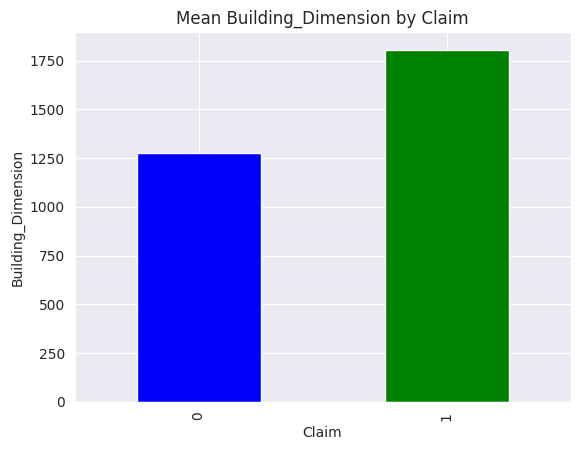

In [31]:
mask_Building_Dimension.plot(
    kind = "bar",
    xlabel = "Claim",
    ylabel = "Building_Dimension",
    title = "Mean Building_Dimension by Claim",
    color=['blue', 'green']  # Specify the colors you want for each bar
);

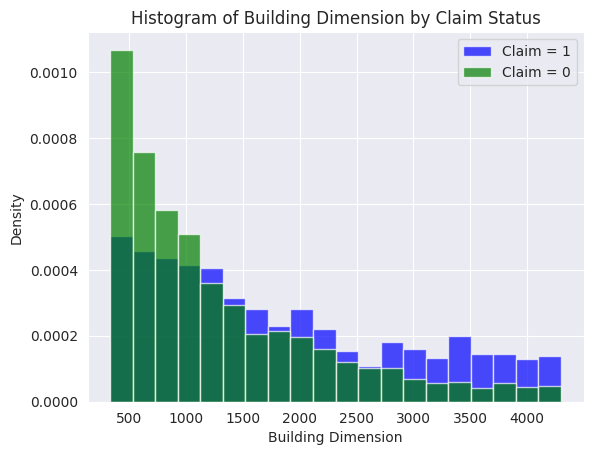

In [32]:
# Separate the data based on the 'Claim' values
claim_1 = df[df['Claim'] == 1]
claim_0 = df[df['Claim'] == 0]

# Create a histogram for 'Building Dimension' by 'Claim' category
plt.hist(claim_1['Building Dimension'], bins=20, alpha=0.7, color='blue', label='Claim = 1', density=True)
plt.hist(claim_0['Building Dimension'], bins=20, alpha=0.7, color='green', label='Claim = 0', density=True)

plt.xlabel('Building Dimension')
plt.ylabel('Density')
plt.title('Histogram of Building Dimension by Claim Status')
plt.legend()

plt.show()







The customers  who have at least a claim over the insured  , their houses have a relatively higher dimension compared to those who had no claim

### Distribution Date of Occupancy and Claim

In [33]:
## Date_of_Occupancy
df["Date_of_Occupancy"].unique()

array([1960., 1980., 1988., 1970., 1950., 1940., 1920., 1982., 1972.,
       1971., 1995., 1999., 1985., 1965., 1981., 1975., 1997., 1990.,
       1930., 1973., 1991., 1974., 1967., 1957., 1978., 1949., 1951.,
       1962., 1956., 1983., 1954., 1968., 1936., 1953., 1979., 1946.,
       1955., 1976., 1961., 1964., 1984., 1958., 1986., 1993., 1977.,
       1945., 1942., 1939., 1934., 1998., 1987., 1938., 1992., 1959.,
       1966., 1989., 1996., 1963., 1948., 1952., 1969., 1994., 1931.,
       1925., 1937., 1935., 1923., 1924., 1928., 1947., 1929.])

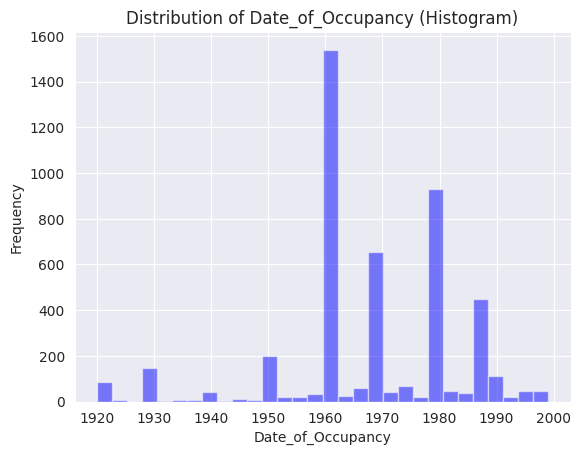

In [34]:
# Exploring the Date of occupancy  before dealing with missing values using a box plot 
plt.hist(df["Date_of_Occupancy"], bins=30, color='blue', alpha=0.5)
plt.xlabel("Date_of_Occupancy")
plt.ylabel("Frequency")
plt.title("Distribution of Date_of_Occupancy (Histogram)")
plt.show()

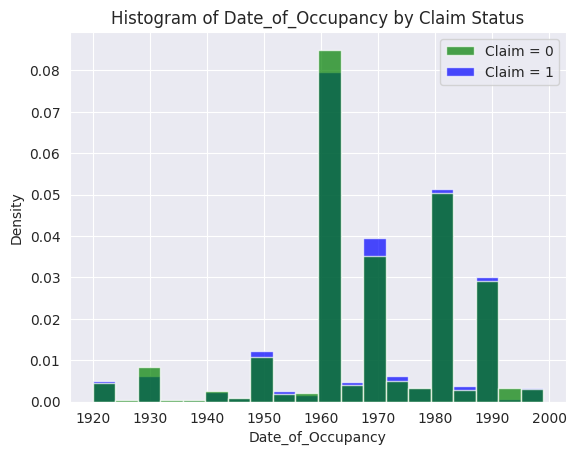

In [16]:
# Separate the data based on the 'Claim' values
claim_1 = df[df['Claim'] == 1]
claim_0 = df[df['Claim'] == 0]

# Create a histogram for 'Building Dimension' by 'Claim' category
plt.hist(claim_1['Date_of_Occupancy'], bins=20, alpha=0.7, color='blue', label='Claim = 1', density=True)
plt.hist(claim_0['Date_of_Occupancy'], bins=20, alpha=0.7, color='green', label='Claim = 0', density=True)

plt.xlabel('Date_of_Occupancy')
plt.ylabel('Density')
plt.title('Histogram of Date_of_Occupancy by Claim Status')
plt.legend()
# reordering the labels 
handles, labels = plt.gca().get_legend_handles_labels() 
  
# specify order 
#order = [1,0] 
  
# pass handle & labels lists along with order as below 
#plt.legend([handles[i] for i in order], [labels[i] for i in order]) 

#plt.show()

In [7]:
mask_Date_of_Occupancy = df.groupby("Claim")["Date_of_Occupancy"].mean()
mask_Date_of_Occupancy

Claim
0    1967.839406
1    1968.349643
Name: Date_of_Occupancy, dtype: float64

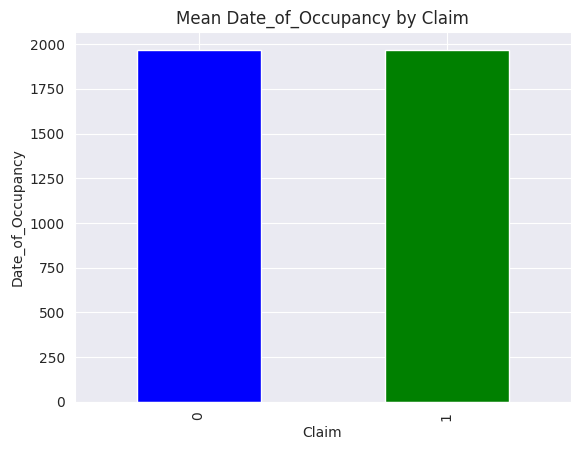

In [8]:
mask_Date_of_Occupancy.plot(
    kind = "bar",
    xlabel = "Claim",
    ylabel = "Date_of_Occupancy",
    title = "Mean Date_of_Occupancy by Claim",
    color=['blue', 'green']  # Specify the colors you want for each bar
);

### 2. Exploratory Data Analysis of Categorical  Variables 

In [104]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7160 entries, 0 to 7159
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Customer Id         7160 non-null   object 
 1   YearOfObservation   7160 non-null   int64  
 2   Insured_Period      7160 non-null   float64
 3   Residential         7160 non-null   int64  
 4   Building_Painted    7160 non-null   object 
 5   Building_Fenced     7160 non-null   object 
 6   Garden              7160 non-null   object 
 7   Settlement          7160 non-null   object 
 8   Building Dimension  7160 non-null   float64
 9   Building_Type       7160 non-null   int64  
 10  Date_of_Occupancy   7160 non-null   float64
 11  NumberOfWindows     7160 non-null   object 
 12  Geo_Code            7160 non-null   object 
 13  Claim               7160 non-null   int64  
dtypes: float64(3), int64(4), object(7)
memory usage: 783.2+ KB


### Distribution of Residential and Claim

In [20]:
# Exploring Residential 
df["Residential"].value_counts()

Residential
0    3310
1    1376
Name: count, dtype: int64

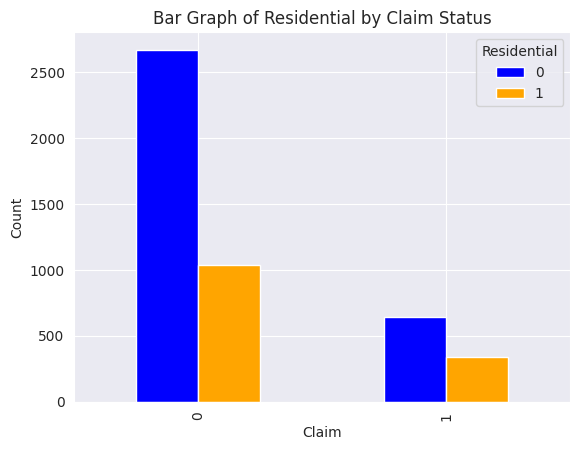

In [11]:
# Create a crosstab to count the occurrences
crosstab = pd.crosstab(df['Claim'], df['Residential'])

# Create a bar graph
crosstab.plot(kind='bar', stacked=False, color=['blue', 'orange'])

plt.xlabel('Claim')
plt.ylabel('Count')
plt.title('Bar Graph of Residential by Claim Status')

plt.show()

### Distribution of Building_Painted and its relationship with claim

In [110]:
# Exploring Building_Painted
df["Building_Painted"].value_counts()

Building_Painted
V    5382
N    1778
Name: count, dtype: int64

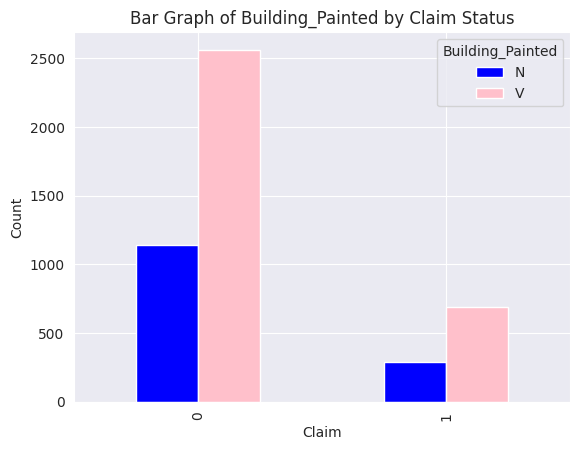

In [4]:
# Create a crosstab to count the occurrences
crosstab = pd.crosstab(df['Claim'], df['Building_Painted'])

# Create a bar graph
crosstab.plot(kind='bar', stacked=False, color=['blue', 'pink'])

plt.xlabel('Claim')
plt.ylabel('Count')
plt.title('Bar Graph of Building_Painted by Claim Status')

plt.show()

In [112]:
# Exploring Building_Fenced
df["Building_Fenced"].value_counts()

Building_Fenced
N    3608
V    3552
Name: count, dtype: int64

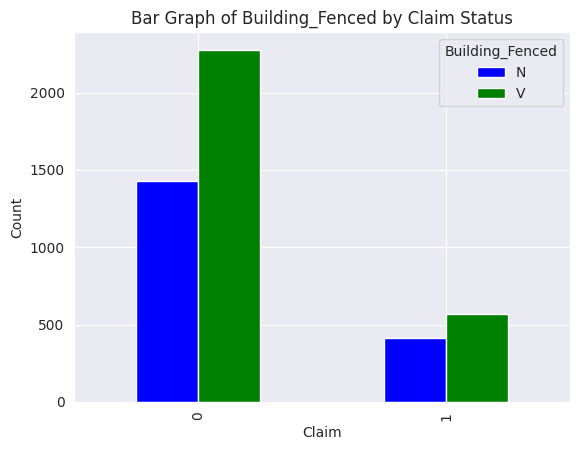

In [5]:
# Create a crosstab to count the occurrences
crosstab = pd.crosstab(df['Claim'], df['Building_Fenced'])

# Create a bar graph
crosstab.plot(kind='bar', stacked=False, color=['blue', 'green'])

plt.xlabel('Claim')
plt.ylabel('Count')
plt.title('Bar Graph of Building_Fenced by Claim Status')

plt.show()

### Distribution of Garden and its relationship with claim

In [115]:
# Exploring Garden
df["Garden"].value_counts()

Garden
O    3609
V    3551
Name: count, dtype: int64

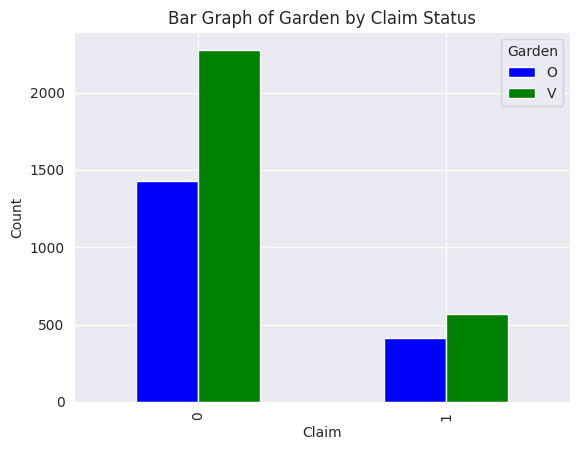

In [6]:
# Create a crosstab to count the occurrences
crosstab = pd.crosstab(df['Claim'], df['Garden'])

# Create a bar graph
crosstab.plot(kind='bar', stacked=False, color=['blue', 'green'])

plt.xlabel('Claim')
plt.ylabel('Count')
plt.title('Bar Graph of Garden by Claim Status')

plt.show()

### Distribution of Settlement and its relationship with claim

In [117]:
# Exploring Settlement
df["Settlement"].value_counts()

Settlement
R    3610
U    3550
Name: count, dtype: int64

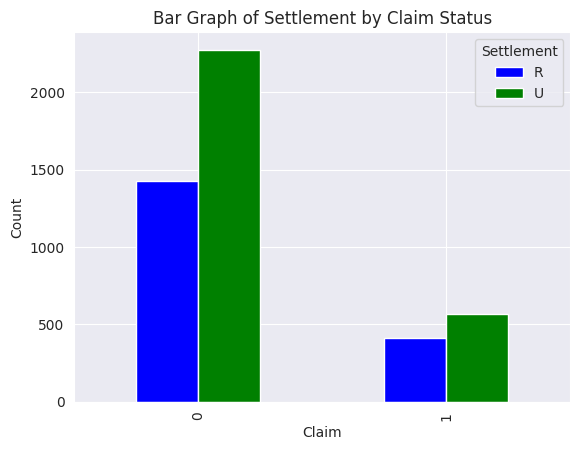

In [7]:
# Create a crosstab to count the occurrences
crosstab = pd.crosstab(df['Claim'], df['Settlement'])

# Create a bar graph
crosstab.plot(kind='bar', stacked=False, color=['blue', 'green'])

plt.xlabel('Claim')
plt.ylabel('Count')
plt.title('Bar Graph of Settlement by Claim Status')

plt.show()

### Distribution of Building_type and its relationship with claim

In [119]:
# Exploring Building_Type
df["Building_Type"].value_counts()

Building_Type
2    3305
1    1716
3    1230
4     909
Name: count, dtype: int64

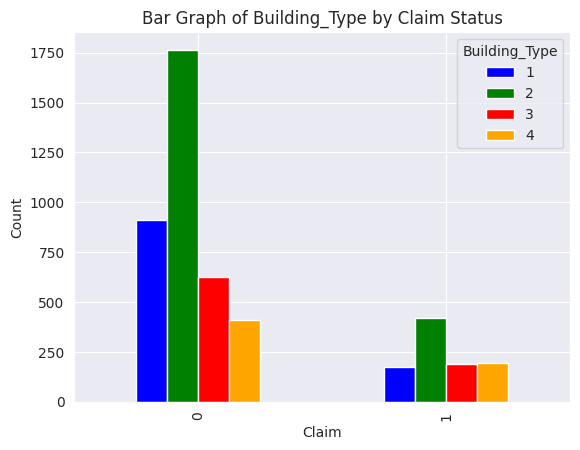

In [8]:
# Create a crosstab to count the occurrences
crosstab = pd.crosstab(df['Claim'], df['Building_Type'])


# Create a bar graph with percentages
ax = crosstab.plot(kind='bar', stacked=False, color=['blue', 'green','red','orange'])

plt.xlabel('Claim')
plt.ylabel('Count')
plt.title('Bar Graph of Building_Type by Claim Status')


plt.show()

### Distribution of Year Of Observation and its relationship with claim

In [39]:
# Exploring YearOfObservation
df["YearOfObservation"].value_counts()

YearOfObservation
2012    1229
2013    1169
2014     900
2015     712
2016     676
Name: count, dtype: int64

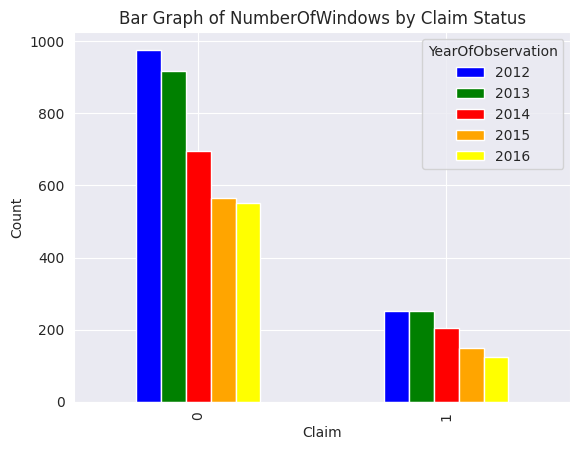

In [10]:
# Create a crosstab to count the occurrences
crosstab = pd.crosstab(df['Claim'], df['YearOfObservation'])


# Create a bar graph with percentages
ax = crosstab.plot(kind='bar', stacked=False, color=['blue', 'green','red','orange','yellow'])

plt.xlabel('Claim')
plt.ylabel('Count')
plt.title('Bar Graph of NumberOfWindows by Claim Status')


plt.show()

### Data Encoding 

In [4]:
# Create a Label Encoder # Change this to One-Hot Encoder 
label_encoder = LabelEncoder()

# Encode categorical columns
categorical_columns = ["Building_Painted", "Building_Fenced", "Garden", "Settlement"]
for column in categorical_columns:
    df[column] = label_encoder.fit_transform(df[column])
print(df)

      YearOfObservation  Insured_Period  Residential  Building_Painted  \
2                  2014        1.000000            0                 0   
3                  2013        1.000000            0                 1   
5                  2012        1.000000            0                 1   
6                  2012        1.000000            0                 0   
10                 2013        0.241096            0                 1   
...                 ...             ...          ...               ...   
7151               2014        0.030137            0                 1   
7153               2013        1.000000            1                 1   
7156               2013        1.000000            0                 1   
7157               2016        0.038251            0                 1   
7158               2013        1.000000            0                 1   

      Building_Fenced  Garden  Settlement  Building Dimension  Building_Type  \
2                   1       1  

In [5]:
# Display the resulting DataFrame with categorical variables encoded as numeric values
df.head()

,YearOfObservation,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Building_Type,Date_of_Occupancy,Claim
2,2014,1.000000,0,0,1,1,1,595.0,1,1960.0,0
3,2013,1.000000,0,1,1,1,1,2840.0,1,1960.0,0
5,2012,1.000000,0,1,0,0,0,535.0,1,1980.0,0
6,2012,1.000000,0,0,1,1,1,2830.0,1,1988.0,0
10,2013,0.241096,0,1,0,0,0,550.0,1,1960.0,0


###  Feature Selection:

In [6]:
# Consider "Building Dimension," "Date_of_Occupancy," and "Insured_Period" as continuous features
continuous_features = ["Building Dimension", "Date_of_Occupancy", "Insured_Period"]
categorical_features = [col for col in df.columns if col not in ["Customer Id", "Claim"] + continuous_features]


In [7]:
# Separate features and target variable
X_continuous = df[continuous_features]
X_categorical = df[categorical_features]
y = df["Claim"]


In [8]:
# Feature selection for continuous features using SelectKBest with F-statistic
k_best_continuous = SelectKBest(score_func=f_classif, k=2)  # Select top 2 continuous features
X_new_continuous = k_best_continuous.fit_transform(X_continuous, y)


In [9]:
# Get the F-statistic values for selected continuous features
f_values_continuous = k_best_continuous.scores_


In [10]:
# Feature selection for categorical features using SelectKBest with chi-squared
k_best_categorical = SelectKBest(score_func=chi2, k=5)  # Select top 5 categorical features
X_new_categorical = k_best_categorical.fit_transform(X_categorical, y)


In [11]:
# Get the chi-squared values for selected categorical features
chi2_values_categorical = k_best_categorical.scores_

In [17]:
# Display the selected continuous features and their F-statistic values
selected_continuous_features = X_continuous.columns[k_best_continuous.get_support()]
print("Selected Continuous Features:")
print(selected_continuous_features)
print("F-Statistic Values for Continuous Features:")
print(f_values_continuous)

Selected Continuous Features:
Index(['Building Dimension', 'Insured_Period'], dtype='object')
F-Statistic Values for Continuous Features:
[234.22576092   0.83600886  30.5367085 ]


In [18]:
# Display the selected categorical features and their chi-squared values
selected_categorical_features = X_categorical.columns[k_best_categorical.get_support()]
print("\nSelected Categorical Features:")
print(selected_categorical_features)
print("Chi-Squared Values for Categorical Features:")
print(chi2_values_categorical)


Selected Categorical Features:
Index(['Residential', 'Building_Fenced', 'Garden', 'Settlement',
       'Building_Type'],
      dtype='object')
Chi-Squared Values for Categorical Features:
[6.47077691e-04 1.18442726e+01 1.85508013e-01 1.59284976e+00
 1.68675481e+00 1.66236534e+00 2.56140549e+01]


In [19]:
# Get the indices of the selected features
selected_continuous_indices = k_best_continuous.get_support(indices=True)
selected_categorical_indices = k_best_categorical.get_support(indices=True)


In [20]:
# Create a new DataFrame with the selected features
selected_features = pd.concat([
    pd.DataFrame(X_new_continuous, columns=X_continuous.columns[selected_continuous_indices]),
    pd.DataFrame(X_new_categorical, columns=X_categorical.columns[selected_categorical_indices])
], axis=1)


In [21]:
# Display the selected features
print("Selected Features:")
print(selected_features)

Selected Features:
      Building Dimension  Insured_Period  Residential  Building_Fenced  \
0                  595.0        1.000000            0                1   
1                 2840.0        1.000000            0                1   
2                  535.0        1.000000            0                0   
3                 2830.0        1.000000            0                1   
4                  550.0        0.241096            0                0   
...                  ...             ...          ...              ...   
4681              1083.0        0.030137            0                1   
4682              1083.0        1.000000            1                1   
4683              1083.0        1.000000            0                1   
4684              1083.0        0.038251            0                1   
4685              1083.0        1.000000            0                1   

      Garden  Settlement  Building_Type  
0          1           1              1  
1       

In [22]:
selected_features.head()

,Building Dimension,Insured_Period,Residential,Building_Fenced,Garden,Settlement,Building_Type
0,595.0,1.000000,0,1,1,1,1
1,2840.0,1.000000,0,1,1,1,1
2,535.0,1.000000,0,0,0,0,1
3,2830.0,1.000000,0,1,1,1,1
4,550.0,0.241096,0,0,0,0,1


### Model Building:

In [15]:
# Creating the feature matrix X and the target variable y
features = ["Building Dimension","Insured_Period","Residential","Building_Fenced","Garden","Settlement","Building_Type"]
X = df[features]
target = "Claim"
y = df[target]


In [16]:
# Splitting the data into training and evaluation sets
X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=0.2, random_state=42)



In [17]:
#Scaling the features using pipeline
pipeline = Pipeline([
            ('std_scaler',StandardScaler()),
                    ])
scaled_X_train = pipeline.fit_transform(X_train)
scaled_X_eval = pipeline.transform(X_eval)

### SVM model 

#### Support Vector Classifier(with default parameters)¶


A support-vector machine constructs a hyperplane or set of hyperplanes in a high- or infinite-dimensional space, which can be used for classification, regression, or other tasks like outliers detection. Intuitively, a good separation is achieved by the hyperplane that has the largest distance to the nearest training-data point of any class (so-called functional margin), since in general the larger the margin, the lower the generalization error of the classifier.



In [18]:
#Fitting the model on SVC with default parameters
model_svc = SVC()
model_svc.fit(scaled_X_train, y_train)

SVC()

In [19]:
#Checking the default parameters in an SVC
model_svc.get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [20]:
#Calculating predictions, and accuracy score
pred_svc = model_svc.predict(scaled_X_eval)
svm = accuracy_score(y_eval,pred_svc)
svm

0.8059701492537313

In [21]:
#Building classification report
print(classification_report(y_eval,pred_svc))

              precision    recall  f1-score   support

           0       0.81      1.00      0.89       754
           1       0.75      0.02      0.03       184

    accuracy                           0.81       938
   macro avg       0.78      0.51      0.46       938
weighted avg       0.80      0.81      0.72       938


In [22]:
# Print the Confusion Matrix and slice it into four pieces

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_eval, pred_svc)

print('Confusion matrix\n\n', cm)

print('\nTrue Positives(TP) = ', cm[0,0])

print('\nTrue Negatives(TN) = ', cm[1,1])

print('\nFalse Positives(FP) = ', cm[0,1])

print('\nFalse Negatives(FN) = ', cm[1,0])

Confusion matrix

 [[753   1]
 [181   3]]

True Positives(TP) =  753

True Negatives(TN) =  3

False Positives(FP) =  1

False Negatives(FN) =  181


In [24]:
# compute ROC AUC

from sklearn.metrics import roc_auc_score

ROC_AUC = roc_auc_score(y_eval, pred_svc)

print('ROC AUC : {:.4f}'.format(ROC_AUC))

ROC AUC : 0.5075


We get an accuracy of 80.6% without tuning the hyperparameters. So let's try tuning the hyperparameters and check if it improves our accuracy

### Hyperparameter Tuning with GridSearchCV

When training an SVM with the Radial Basis Function (RBF) kernel, two parameters must be considered: C and gamma. The parameter C, common to all SVM kernels, trades off misclassification of training examples against simplicity of the decision surface. A low C makes the decision surface smooth, while a high C aims at classifying all training examples correctly. gamma defines how much influence a single training example has. The larger gamma is, the closer other examples must be to be affected.

In [26]:
# Create a dictionary called param_grid and fill out some parameters for kernels, C and gamma
param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'poly', 'sigmoid']}


In [ ]:
# Create a GridSearchCV object and fit it to the training data
grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=2)
grid.fit(X_train,y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.8s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   1.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.9s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.9s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.8s


In [ ]:
# Find the optimal parameters
print(grid.best_estimator_)

### LInear Regression

In [25]:
#Create a linear regression model
model = LinearRegression()

In [26]:
#Fit the model on the training data
model.fit(X_train, y_train)

LinearRegression()

In [27]:
# Step 5: Make predictions on the test set
y_pred = model.predict(X_eval)

In [30]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
# Step 6: Evaluate the model before hyperparameter tuning
mse = mean_squared_error(y_eval, y_pred)
r2 = r2_score(y_eval, y_pred)
rmse = mean_squared_error(y_eval, y_pred, squared=False)
print(f'Mean Squared Error (Before Hyperparameter Tuning): {mse}')
print(f'Root Mean Squared Error (Before Hyperparameter Tuning): {rmse}')
print(f'R-squared (R2): {r2}')

Mean Squared Error (Before Hyperparameter Tuning): 0.14694812081318834
Root Mean Squared Error (Before Hyperparameter Tuning): 0.3833381285669198
R-squared (R2): 0.06807589660391788


In [38]:
# Define the parameter grid
param_grid = {
    'fit_intercept': [True, False],
    'positive': [True, False]
}

In [39]:
# Create the GridSearchCV object
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)


In [40]:
# Fit the grid search to the data
grid_search.fit(X_train, y_train)


GridSearchCV(cv=5, estimator=LinearRegression(), n_jobs=-1,
             param_grid={'fit_intercept': [True, False],
                         'positive': [True, False]},
             scoring='neg_mean_squared_error')

In [41]:
# Get the best parameters and best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

In [42]:
# Make predictions on the test set
y_pred = best_model.predict(X_eval)



In [43]:
# Evaluate the model
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score


mse = mean_squared_error(y_eval, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_eval, y_pred)

print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'R-squared (R2): {r2}')

Mean Squared Error (MSE): 0.1469504780865254
Root Mean Squared Error (RMSE): 0.38334120322048004
R-squared (R2): 0.06806094711134214


In [44]:
# compute ROC AUC

from sklearn.metrics import roc_auc_score

ROC_AUC = roc_auc_score(y_eval,y_pred )

print('ROC AUC : {:.4f}'.format(ROC_AUC))

ROC AUC : 0.6789


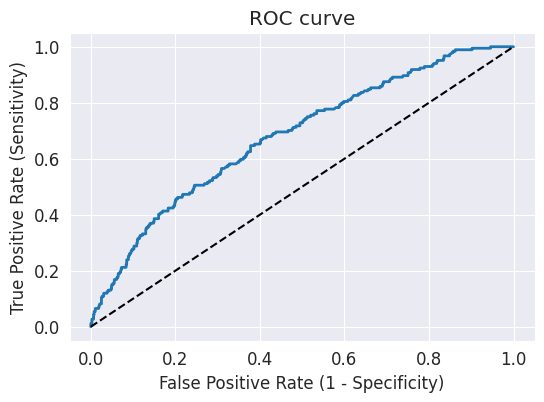

In [46]:
# plot ROC Curve

from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_eval, y_pred)

plt.figure(figsize=(6,4))

plt.plot(fpr, tpr, linewidth=2)

plt.plot([0,1], [0,1], 'k--' )

plt.rcParams['font.size'] = 12

plt.title('ROC curve' )

plt.xlabel('False Positive Rate (1 - Specificity)')

plt.ylabel('True Positive Rate (Sensitivity)')

plt.show()

### KNN

In [47]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn

KNeighborsClassifier()

In [48]:
from sklearn import metrics
mean_acc = np.zeros(20)
for i in range(1,21):
    #Train Model and Predict  
    knn = KNeighborsClassifier(n_neighbors = i).fit(X_train, y_train)
    yhat= knn.predict(X_eval)
    mean_acc[i-1] = metrics.accuracy_score(y_eval, yhat)

mean_acc

array([0.70255864, 0.79104478, 0.75586354, 0.78891258, 0.7803838 ,
       0.79637527, 0.78571429, 0.78997868, 0.79530917, 0.80063966,
       0.79317697, 0.79957356, 0.79850746, 0.79744136, 0.79744136,
       0.79317697, 0.79424307, 0.79424307, 0.79530917, 0.79424307])

#### Hyperparameter Tuning for KNN

We will use the Exhaustive Grid Search technique for hyperparameter optimization. An exhaustive grid search takes in as many hyperparameters as you would like, and tries every single possible combination of the hyperparameters as well as as many cross-validations as you would like it to perform. An exhaustive grid search is a good way to determine the best hyperparameter values to use, but it can quickly become time consuming with every additional parameter value and cross-validation that you add.

In [49]:
grid_params = { 'n_neighbors' : [2,6,10,12,20],
               'weights' : ['uniform','distance'],
               'metric' : ['minkowski','euclidean','manhattan']}

In [50]:
gs = GridSearchCV(KNeighborsClassifier(), grid_params, verbose = 1, cv=3, n_jobs = -1)


In [51]:
# fit the model on our train set
g_res = gs.fit(X_train, y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


In [52]:
# find the best score
g_res.best_score_

0.7822827862289832

In [53]:
# get the hyperparameters with the best score
g_res.best_params_

{'metric': 'manhattan', 'n_neighbors': 12, 'weights': 'uniform'}

In [54]:
# use the best hyperparameters
g_res.best_params_
knn = KNeighborsClassifier(n_neighbors = 20, weights = 'uniform',algorithm = 'brute',metric = 'minkowski')
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='brute', n_neighbors=20)

In [55]:
# get a prediction
y_hat = knn.predict(X_train)
y_knn = knn.predict(X_eval)

In [56]:
# Model Evaluation
print('Training set accuracy: ', metrics.accuracy_score(y_train, y_hat))
print('Test set accuracy: ',metrics.accuracy_score(y_eval, y_knn))
sc = metrics.accuracy_score(y_eval, y_knn)

Training set accuracy:  0.7897545357524013
Test set accuracy:  0.7942430703624733


In [57]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_eval, y_knn))

[[739  15]
 [178   6]]


In [58]:
print(classification_report(y_eval, y_knn))

              precision    recall  f1-score   support

           0       0.81      0.98      0.88       754
           1       0.29      0.03      0.06       184

    accuracy                           0.79       938
   macro avg       0.55      0.51      0.47       938
weighted avg       0.70      0.79      0.72       938


In [61]:
# compute ROC AUC

from sklearn.metrics import roc_auc_score

ROC_AUC = roc_auc_score(y_eval,y_knn )

print('ROC AUC : {:.4f}'.format(ROC_AUC))

ROC AUC : 0.5064


### Naive Bayes

In [37]:
from sklearn.model_selection import cross_val_score
model = GaussianNB()
cv_scores = cross_val_score(model,X_train, y_train, cv=5)
    
print(model, ' mean accuracy: ', round(cv_scores.mean()*100, 3), '% std: ', round(cv_scores.var()*100, 3),'%')

GaussianNB()  mean accuracy:  77.641 % std:  0.006 %


In [38]:
predict_train = model.fit(X_train, y_train).predict(X_train)

# Accuray Score on train dataset
accuracy_train = accuracy_score(y_train,predict_train)
print('accuracy_score on train dataset : ', accuracy_train)


# predict the target on the test dataset
predict_test = model.predict(X_eval)

# Accuracy Score on test dataset
accuracy_test = accuracy_score(y_eval,predict_test)
print('accuracy_score on test dataset : ', accuracy_test)

accuracy_score on train dataset :  0.7772145144076841
accuracy_score on test dataset :  0.7867803837953091


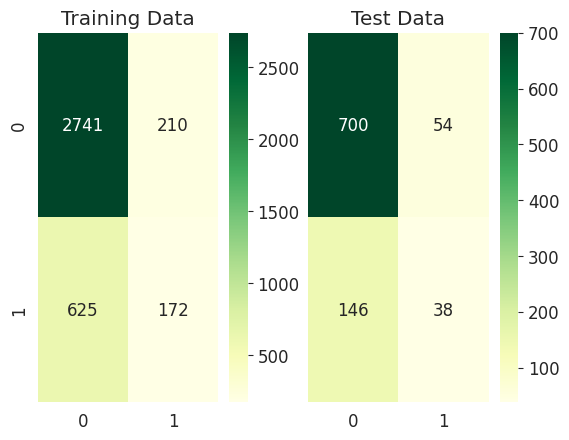

In [39]:
# Cnfusion matrix
from sklearn import metrics
f,a =  plt.subplots(1,2,sharex=True,sharey=True,squeeze=False)

#Plotting confusion matrix for the different models for the Training Data

plot_0 = sns.heatmap((metrics.confusion_matrix(y_train,predict_train)),annot=True,fmt='.5g',cmap="YlGn",ax=a[0][0]);
a[0][0].set_title('Training Data')

plot_1 = sns.heatmap((metrics.confusion_matrix(y_eval,predict_test)),annot=True,fmt='.5g',cmap="YlGn",ax=a[0][1]);
a[0][1].set_title('Test Data');

In [40]:
# Classification report
from sklearn.metrics import roc_auc_score,roc_curve,classification_report,confusion_matrix,ConfusionMatrixDisplay
print(classification_report(y_train,predict_train))
print(classification_report(y_eval,predict_test))

              precision    recall  f1-score   support

           0       0.81      0.93      0.87      2951
           1       0.45      0.22      0.29       797

    accuracy                           0.78      3748
   macro avg       0.63      0.57      0.58      3748
weighted avg       0.74      0.78      0.75      3748

              precision    recall  f1-score   support

           0       0.83      0.93      0.88       754
           1       0.41      0.21      0.28       184

    accuracy                           0.79       938
   macro avg       0.62      0.57      0.58       938
weighted avg       0.75      0.79      0.76       938


##### Hyperparameter Tuning to improve Accuracy

Var_smoothing (Variance smoothing) parameter specifies the portion of the largest variance of all features to be added to variances for stability of calculation.

Gaussian Naive Bayes assumes that features follows normal distribution which is most unlikely in real world.So solve this problem we can perform "power transformation" on each feature to make it more or less normally distributed. By default, PowerTransformer results in features that have a 0 mean and 1 standard deviation.


In [67]:
from sklearn.model_selection import RepeatedStratifiedKFold

cv_method = RepeatedStratifiedKFold(n_splits=5, 
                                    n_repeats=3, 
                                    random_state=999)

In [98]:
from sklearn.preprocessing import PowerTransformer
params_NB = {'var_smoothing': np.logspace(0,-9, num=100)}

gs_NB = GridSearchCV(estimator=model, 
                     param_grid=params_NB, 
                     cv=cv_method,
                     verbose=1, 
                     scoring='accuracy')

Data_transformed = PowerTransformer().fit_transform(X_train)

gs_NB.fit(Data_transformed, y_train);

Fitting 15 folds for each of 100 candidates, totalling 1500 fits


In [99]:
gs_NB.best_params_


{'var_smoothing': 0.15199110829529336}

In [100]:
gs_NB.best_score_

0.7883321762349799

In [101]:
results_NB = pd.DataFrame(gs_NB.cv_results_['params'])
results_NB['test_score'] = gs_NB.cv_results_['mean_test_score']

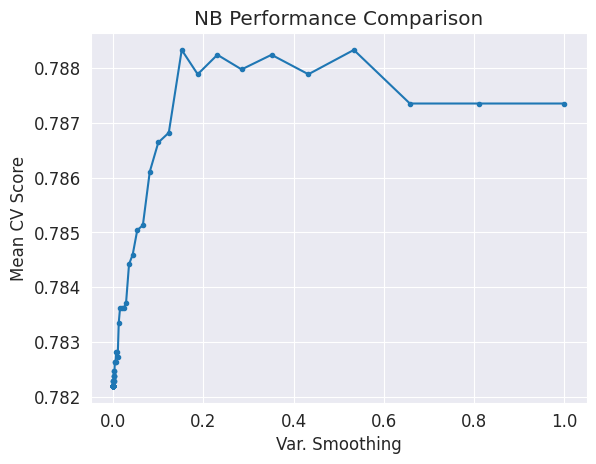

In [102]:
plt.plot(results_NB['var_smoothing'], results_NB['test_score'], marker = '.')    
plt.xlabel('Var. Smoothing')
plt.ylabel("Mean CV Score")
plt.title("NB Performance Comparison")
plt.show()


In [103]:
# predict the target on the test dataset
predict_test = gs_NB.predict(Data_transformed)

# Accuracy Score on test dataset
accuracy_test = accuracy_score(y_train,predict_test)
print('accuracy_score on test dataset : ', accuracy_test)

accuracy_score on test dataset :  0.7878868729989328


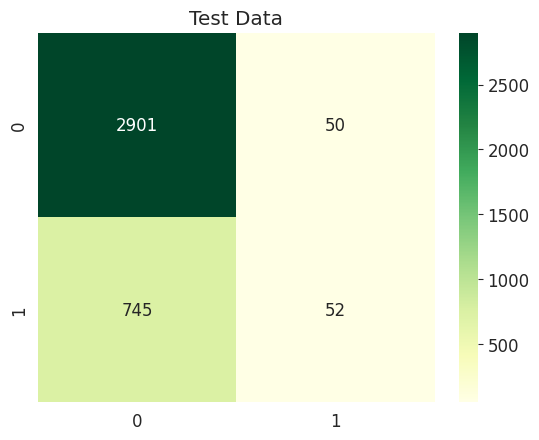

In [104]:
sns.heatmap((metrics.confusion_matrix(y_train,predict_test)),annot=True,fmt='.5g',cmap="YlGn").set_title('Test Data');

In [105]:
# compute ROC AUC

from sklearn.metrics import roc_auc_score

ROC_AUC = roc_auc_score(y_train,predict_test)

print('ROC AUC : {:.4f}'.format(ROC_AUC))

ROC AUC : 0.5242


In [31]:
# plot ROC Curve

from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train, predict_test)

plt.figure(figsize=(6,4))

plt.plot(fpr, tpr, linewidth=2)

plt.plot([0,1], [0,1], 'k--' )

plt.rcParams['font.size'] = 12

plt.title('ROC curve for Predicting NB')

plt.xlabel('False Positive Rate (1 - Specificity)')

plt.ylabel('True Positive Rate (Sensitivity)')

plt.show()

NameError: name 'predict_test' is not defined

### Making predictions 

In [115]:
df2 = wrangle("test_data.csv")
print("df shape", df.shape)
df2.info()

df shape (4686, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3069 entries, 0 to 3068
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Customer Id         3069 non-null   object 
 1   YearOfObservation   3069 non-null   int64  
 2   Insured_Period      3069 non-null   float64
 3   Residential         3069 non-null   int64  
 4   Building_Painted    3069 non-null   object 
 5   Building_Fenced     3069 non-null   object 
 6   Garden              3069 non-null   object 
 7   Settlement          3069 non-null   object 
 8   Building Dimension  3069 non-null   float64
 9   Building_Type       3069 non-null   int64  
 10  Date_of_Occupancy   3069 non-null   float64
dtypes: float64(3), int64(3), object(5)
memory usage: 263.9+ KB


In [116]:
# Create a LabelEncoder
label_encoder = LabelEncoder()

# Encode categorical columns
categorical_columns = ["Building_Painted", "Building_Fenced", "Garden", "Settlement"]
for column in categorical_columns:
    df2[column] = label_encoder.fit_transform(df2[column])
print(df2)

     Customer Id  YearOfObservation  Insured_Period  Residential  \
0         H11920               2013        1.000000            0   
1         H11921               2016        0.997268            0   
2          H9805               2013        0.369863            0   
3          H7493               2014        1.000000            0   
4          H7494               2016        1.000000            0   
...          ...                ...             ...          ...   
3064      H11583               2015        1.000000            0   
3065      H11720               2012        1.000000            0   
3066      H11721               2012        1.000000            0   
3067      H12408               2013        1.000000            0   
3068       H9021               2012        1.000000            0   

      Building_Painted  Building_Fenced  Garden  Settlement  \
0                    1                0       0           0   
1                    1                0       0          

In [117]:
features1 = ["Building Dimension","Insured_Period","Residential","Building_Fenced","Garden","Settlement","Building_Type"]
X_pred1 =df2[features1]

In [118]:
X_pred1.head()

,Building Dimension,Insured_Period,Residential,Building_Fenced,Garden,Settlement,Building_Type
0,300.0,1.000000,0,0,0,0,1
1,300.0,0.997268,0,0,0,0,1
2,790.0,0.369863,0,1,1,1,1
3,1405.0,1.000000,0,0,0,0,1
4,1405.0,1.000000,0,0,0,0,1


In [119]:
# Assuming you have a pipeline with a StandardScaler
scaled_X_pred1 = pipeline.transform(X_pred1)

### SVM preictions

In [120]:
# Make predictions using the trained SVM model
predictions = model_svc.predict(scaled_X_pred1)

In [121]:
# Create a new DataFrame with the predictions
output_df = pd.DataFrame({'Predictions': predictions})

In [122]:
# Assuming df2 has a column named 'Customer ID'
customer_ids = df2["Customer Id"]

In [123]:
# Create a DataFrame with Customer ID and Predictions
output_df = pd.DataFrame({'Customer ID': customer_ids, 'Predictions': predictions})

In [124]:
# Print the predictions
print(output_df)

     Customer ID  Predictions
0         H11920            0
1         H11921            0
2          H9805            0
3          H7493            0
4          H7494            0
...          ...          ...
3064      H11583            0
3065      H11720            0
3066      H11721            0
3067      H12408            0
3068       H9021            0

[3069 rows x 2 columns]


In [126]:
# Save the predictions to a CSV file
output_df.to_csv('SVM_output.csv', index=False)

### Prediction for linear Regression

In [138]:
# Make predictions using the trained Linear Regression Model model
predictionsL = best_model.predict(X_pred1)
# Create a new DataFrame with the predictions
output_dfL = pd.DataFrame({'Predictions': predictionsL})
# Assuming df2 has a column named 'Customer ID'
customer_idsL = df2["Customer Id"]
# Create a DataFrame with Customer ID and Predictions
output_dfL = pd.DataFrame({'Customer ID': customer_idsL, 'Predictions': predictionsL})
# Print the predictions
print(output_dfL)
# Save the predictions to a CSV file
output_dfL.to_csv('Linear_Regression_output.csv', index=False)

     Customer ID  Predictions
0         H11920     0.057437
1         H11921     0.057089
2          H9805     0.028375
3          H7493     0.158109
4          H7494     0.158109
...          ...          ...
3064      H11583     0.265057
3065      H11720     0.167324
3066      H11721     0.167324
3067      H12408     0.118458
3068       H9021     0.167324

[3069 rows x 2 columns]


### Prediction for KNN

In [137]:
# Make predictions using the trained SVM model
predictionsK = knn.predict(X_pred1)
# Create a new DataFrame with the predictions
output_dfK = pd.DataFrame({'Predictions': predictionsK})
# Assuming df2 has a column named 'Customer ID'
customer_idsK = df2["Customer Id"]
# Create a DataFrame with Customer ID and Predictions
output_dfK = pd.DataFrame({'Customer ID': customer_idsK, 'Predictions': predictionsK})
# Print the predictions
print(output_dfK)
# Save the predictions to a CSV file
output_dfK.to_csv('KNN_output.csv', index=False)

     Customer ID  Predictions
0         H11920            0
1         H11921            0
2          H9805            0
3          H7493            0
4          H7494            0
...          ...          ...
3064      H11583            0
3065      H11720            0
3066      H11721            0
3067      H12408            0
3068       H9021            0

[3069 rows x 2 columns]


In [ ]:
### Prediction for Naive Bayes 

In [139]:
# Make predictions using the trained SVM model
predictionsB = gs_NB.predict(X_pred1)
# Create a new DataFrame with the predictions
output_dfB = pd.DataFrame({'Predictions': predictionsB})
# Assuming df2 has a column named 'Customer ID'
customer_idsB = df2["Customer Id"]
# Create a DataFrame with Customer ID and Predictions
output_dfB = pd.DataFrame({'Customer ID': customer_idsB, 'Predictions': predictionsB})
# Print the predictions
print(output_dfB)
# Save the predictions to a CSV file
output_dfB.to_csv('Naive_Bayes_output.csv', index=False)

     Customer ID  Predictions
0         H11920            1
1         H11921            1
2          H9805            1
3          H7493            1
4          H7494            1
...          ...          ...
3064      H11583            1
3065      H11720            1
3066      H11721            1
3067      H12408            1
3068       H9021            1

[3069 rows x 2 columns]


In [453]:
models = pd.DataFrame({
    'Model': ['Support Vector Machines','Linear Regression', 'KNN','Naive Bayes'],
   'Score': [svm, r2 , sc ,accuracy_test]})
models.sort_values(by='Score', ascending=False)

,Model,Score
0,Support Vector Machines,0.805970
2,KNN,0.794243
3,Naive Bayes,0.787887
1,Linear Regression,0.068061
